In [31]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_palette("pastel")

import missingno as msno
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.under_sampling import RandomUnderSampler

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.linalg import sqrtm
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


In [1]:
os.listdir()

['.ipynb_checkpoints',
 '.vscode',
 'DH-LCM_v1.py',
 'DHLCM-v1_2.ipynb',
 'patient-risk-profiles.zip',
 'patient_risk_profiles.csv']

In [2]:
df = pd.read_csv("patient_risk_profiles.csv")

In [3]:
df = df.drop(columns=['predicted risk of Pulmonary Embolism', 'predicted risk of Sudden Hearing Loss, No congenital anomaly or middle or inner ear conditions',
 'predicted risk of Restless Leg Syndrome',
 'predicted risk of Sudden Vision Loss, with no eye pathology causes',
 'predicted risk of Muscle weakness or injury',
 'predicted risk of Ankylosing Spondylitis',
 'predicted risk of Autoimmune hepatitis',
 'predicted risk of Multiple Sclerosis',
 'predicted risk of Acute pancreatitis, with No chronic or hereditary or common causes of pancreatitis',
 'predicted risk of Ulcerative colitis',
 'predicted risk of Migraine',
 'predicted risk of Dementia',
 'predicted risk of  Treatment resistant depression (TRD)',
 "predicted risk of Parkinson's disease, inpatient or with 2nd diagnosis"])

In [19]:
df.columns.tolist()

['personId',
 'age group:  10 -  14',
 'age group:  15 -  19',
 'age group:  20 -  24',
 'age group:  65 -  69',
 'age group:  40 -  44',
 'age group:  45 -  49',
 'age group:  55 -  59',
 'age group:  85 -  89',
 'age group:  75 -  79',
 'age group:   5 -   9',
 'age group:  25 -  29',
 'age group:   0 -   4',
 'age group:  70 -  74',
 'age group:  50 -  54',
 'age group:  60 -  64',
 'age group:  35 -  39',
 'age group:  30 -  34',
 'age group:  80 -  84',
 'age group:  90 -  94',
 'Sex = FEMALE',
 'Sex = MALE',
 'Acetaminophen exposures in prior year',
 'Occurrence of Alcoholism in prior year',
 'Anemia in prior year',
 'Angina events in prior year',
 'ANTIEPILEPTICS in prior year',
 'Occurrence of Anxiety in prior year',
 'Osteoarthritis in prior year',
 'Aspirin exposures in prior year',
 'Occurrence of Asthma in prior year',
 'Atrial Fibrillation, incident in prior year',
 'HORMONAL CONTRACEPTIVES in prior year',
 'Any cancer (excl. prostate cancer and benign cancer) in prior yea

In [4]:
col = df[['Sex = FEMALE', 'Sex = MALE']]
col

condition = (df['Sex = FEMALE'] == 0) & (df['Sex = MALE'] == 1) | (df['Sex = FEMALE'] == 1) & (df['Sex = MALE'] == 0) 



In [7]:
false_rows = df[~condition]

# Print the rows where the condition is False
print(len(false_rows))

0


In [6]:
df = df.drop(index=false_rows.index)

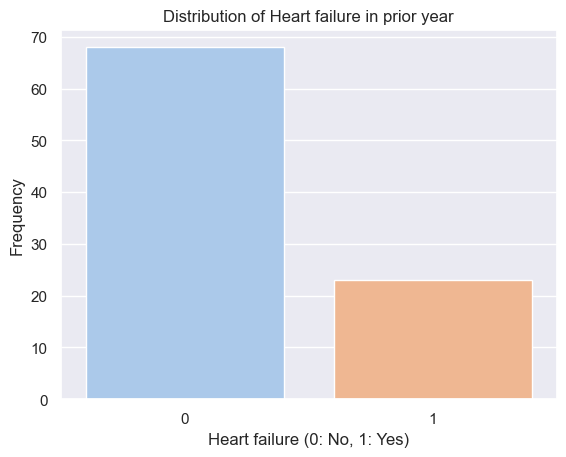

In [8]:
sns.countplot(data=df, x='Heart failure in prior year')
plt.title('Distribution of Heart failure in prior year')
plt.xlabel('Heart failure (0: No, 1: Yes)')
plt.ylabel('Frequency')
plt.show()

In [9]:
df_X = df.drop(columns=['Heart failure in prior year','personId'])
df_Y = df['Heart failure in prior year'].astype(int)


In [27]:
print('Original dataset shape %s' % Counter(df_Y))

Original dataset shape Counter({0: 23, 1: 23})


In [26]:
rus = RandomUnderSampler(random_state=1313)
df_X_rus, df_Y_rus =rus.fit_resample(df_X, df_Y)

In [29]:
print('Resampled dataset shape %s' % Counter(df_Y_rus))

Resampled dataset shape Counter({0: 23, 1: 23})


In [34]:
def hetero_clustering(df_X_rus, K,TO):
    R = df_X_rus.to_numpy()
    
    Ub = hetero_pca(R, K, TO)
    
    Ue = np.diag(1/np.linalg.norm(Ub, axis=1)) @ Ub
    
    kmeans = KMeans(n_clusters=K)
    
    bs = kmeans.fit_predict(Ue)
    
    Theta = estimate_theta(R, bs, K)
    
    return bs, Theta


def hetero_pca(R, K, T0):
    M = R @ R.T
    
    for _ in range(T0):
        U, s, Vh = np.linalg.svd(M, full_matrices=False)
        M = np.dot(U[:,:K], np.dot(np.diag(s[:K]), Vh[:K, :]))  
        
        M = 0.5 * (M + M.T)

    Uc = np.linalg.eigh(M)[1][:, ::-1][:, :K]
    return Uc

                                             
def estimate_theta(R, labels, K):
    Theta = np.zeros((R.shape[1], K))
    
    for k in range(K):
        cluster_samples = R[labels == k]
        avg_sample = np.mean(cluster_samples, axis=0)
        # Correct for degree effects if necessary
        # For example, you can apply some form of normalization here if needed
        Theta[:, k] = avg_sample
    
    return Theta

In [38]:
# Assuming df_X_rus is your dataset DataFrame and TO is the desired number of iterations for PCA
K = 2  # Number of clusters
TO = 100  # Number of iterations for PCA

# Call the hetero_clustering function to find 2 clusters
cluster_assignments, cluster_parameters = hetero_clustering(df_X_rus, K, TO)

# Output cluster assignments and parameters
print("Cluster Assignments:", cluster_assignments)
print("Cluster Parameters:\n", cluster_parameters)


Cluster Assignments: [0 0 0 1 0 0 0 0 1 1 0 0 1 0 1 0 0 0 1 1 1 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0
 1 1 0 1 0 0 0 0 0]
Cluster Parameters:
 [[0.03125    0.14285714]
 [0.         0.07142857]
 [0.125      0.07142857]
 [0.         0.07142857]
 [0.         0.        ]
 [0.0625     0.        ]
 [0.0625     0.21428571]
 [0.0625     0.        ]
 [0.09375    0.21428571]
 [0.         0.07142857]
 [0.09375    0.        ]
 [0.03125    0.07142857]
 [0.         0.07142857]
 [0.03125    0.        ]
 [0.125      0.        ]
 [0.09375    0.        ]
 [0.03125    0.        ]
 [0.09375    0.        ]
 [0.0625     0.        ]
 [0.         0.92857143]
 [1.         0.07142857]
 [0.03125    0.14285714]
 [0.0625     0.14285714]
 [0.25       0.35714286]
 [0.09375    0.21428571]
 [0.1875     0.        ]
 [0.0625     0.14285714]
 [0.125      0.28571429]
 [0.28125    0.21428571]
 [0.09375    0.21428571]
 [0.25       0.07142857]
 [0.21875    0.07142857]
 [0.125      0.07142857]
 [0.125      0.14285714]
 [0.125      

In [36]:
# Assuming df_Y_rus contains the true labels

# Step 1: Get cluster assignments
cluster_assignments, _ = hetero_clustering(df_X_rus, K, TO)

# Step 2: Get true labels from df_Y_rus
true_labels = df_Y_rus.values.flatten()  # Assuming df_Y_rus is a single-column DataFrame or a Series

# Step 3: Compare cluster assignments to true labels
from sklearn.metrics import adjusted_rand_score

ari = adjusted_rand_score(true_labels, cluster_assignments)
print("Adjusted Rand Index (ARI):", ari)


Adjusted Rand Index (ARI): -0.011474076294044611


In [42]:
print("Cluster Assignments:", cluster_assignments)
print(df_Y_rus)

Cluster Assignments: [0 0 0 1 0 0 0 0 1 1 0 0 1 0 1 0 0 0 1 1 1 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0
 1 1 0 1 0 0 0 0 0]
0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    1
24    1
25    1
26    1
27    1
28    1
29    1
30    1
31    1
32    1
33    1
34    1
35    1
36    1
37    1
38    1
39    1
40    1
41    1
42    1
43    1
44    1
45    1
Name: Heart failure in prior year, dtype: int32
